In [21]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Find Communicative Successes and Failures 

In [2]:
# Communicative success: how many no-xxx, no-yyy child  utterances are in Providence? 
# Communicative failures: how many one-yyy, no-xxx child utterances are in Providence?
# Subset to instances that are monosyllabic later

In [4]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [5]:
phono_glosses = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where \
    actual_phonology != "" and model_phonology != "" and collection_name = "Eng-NA" \
    and corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")

R[write to console]: Using supported database version: '2020.1'.



In [6]:
phono_glosses.corpus_name.value_counts()

Providence    396621
Name: corpus_name, dtype: int64

In [7]:
phono_glosses.loc[phono_glosses.gloss == 'xxx'].actual_phonology.value_counts()

*          26736
ə             10
(.)            7
aɪ             4
ən             2
           ...  
aɪbiwaʊ        1
hɛjə           1
dʒeɪ           1
dulɪ           1
nowədɪ         1
Name: actual_phonology, Length: 76, dtype: int64

Actual phonology is almost always * for xxx items

In [8]:
phono_glosses.loc[phono_glosses.gloss == 'yyy'].actual_phonology.value_counts()

ɛ            3206
ʌ            2132
ɪ            1881
ə             512
o             507
             ... 
pɪkəpɪ          1
kwɪkʰ           1
wiɡuu           1
ɪzn̩də          1
ɛmaɪɡwaɪt       1
Name: actual_phonology, Length: 30293, dtype: int64

Actual phonology is populated for yyy items

In [9]:
chi_phono = phono_glosses.loc[(phono_glosses.speaker_code == 'CHI') & 
    (phono_glosses.target_child_age < (365*5))]

In [10]:
def count_transmission_errors(utt_vector, error_codes):
    return(np.sum([x in error_codes for x in  utt_vector]))

In [11]:
xxxs_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['xxx'])).reset_index()
xxxs_per_utt.columns = ['utterance_id', 'num_xxx']
yyys_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['yyy'])).reset_index()
yyys_per_utt.columns = ['utterance_id', 'num_yyy']
failures_per_utt = xxxs_per_utt.merge(yyys_per_utt)

In [12]:
yyy_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  (failures_per_utt.num_yyy == 1)]

In [12]:
yyy_utts.shape

(31457, 3)

In [13]:
success_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  
    (failures_per_utt.num_yyy == 0)]

In [14]:
success_utts.shape

(83880, 3)

In [14]:
tokens_from_errorless_utts = chi_phono.loc[chi_phono.utterance_id.isin(success_utts.utterance_id)]

In [15]:
#exclude un-transcribed tokens and syllabically transcribed tokens
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
tokens_from_errorless_utts = tokens_from_errorless_utts.loc[~(tokens_from_errorless_utts.actual_phonology.isin(excludes) |
    tokens_from_errorless_utts.model_phonology.isin(excludes))]

In [17]:
tokens_from_errorless_utts.shape

(214239, 12)

In [16]:
# example phonology
tokens_from_errorless_utts.actual_phonology

1          ɑmɪ
3          wiː
4          wiː
5           uː
52           ɛ
          ... 
396606       o
396607     waɪ
396608     liʔ
396609       ɪ
396610    hɪpo
Name: actual_phonology, Length: 214239, dtype: object

In [19]:
# 31,457 transmission errors (from 31,457 utterances)
# 214,239 transmission successes (from 83,880 utterances)
# this will be further decreased later by the need to test monosyllabic forms

# Prevalence of communication failures by age 

In [17]:
chi_phono = chi_phono.loc[chi_phono.gloss != "xxx"]
chi_phono.shape

(369789, 12)

In [18]:
error_codes = ('yyy')

In [ ]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

In [19]:
error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

AttributeError: 'DataFrameGroupBy' object has no attribute 'target_child_age_months'

In [24]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

In [ ]:
%%R -w 600 -h 600

pvd_comm_error = subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')

pvd_comm_error$age_in_months = pvd_comm_error$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

ggplot(pvd_comm_error) + geom_point(aes(x=target_child_age_months, 
y=proportion_errors, color= "collection_name"), alpha=.5) + theme_classic(base_size =32) + xlab('Child Age in Months') + ylab(
'Proportion of Comm. Failures (yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors),  linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black')  + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months) + geom_hline(yintercept=0,
    color = "forestgreen") +theme(legend.position="none")

In [ ]:
%%R
# Data for Lvenshtin distances in Providence comes from notebook "Levenshtein distance in Providence"
chi_levdist = read.csv('csv/pvd_levdist.csv')

In [ ]:
%%R -h 600 -w 600
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

p1 = ggplot(subset(chi_levdist, mean_levdist < 100 & corpus_name == 'Providence')) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + theme_classic(base_size = 32) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Articulation Error"
) + xlab('Child Age (Months)') + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
print(p1)

In [ ]:
%%R
chi_levdist$age_in_months = NULL
pvd_comm_error_merged = merge(pvd_comm_error, chi_levdist,
        by=c('transcript_id'))
nrow(pvd_comm_error_merged)

In [ ]:
%%R -w 600 -h 600
names(pvd_comm_error_merged)

p1 = ggplot(pvd_comm_error_merged) + geom_point(aes(x=mean_levdist, y=proportion_errors, 
color=age_in_months), alpha=.5)  + theme_classic(base_size = 32
)  + coord_cartesian(ylim=c(0,1), xlim =c(0,1)) + scale_color_viridis_c(
) + ylab('Proportion of Comm. Failures (yyy)') + xlab('Articulation Error'
) + theme(legend.position=c(.3, .7), legend.background=element_blank()) + labs(color = "Age in Months") 

print(p1)


In [ ]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

In [31]:
# Manually confirm that these transcripts indeed have a very high proportion of errors
# Yep!

# Load BERT Models + CMU Dict

### Get the CMU Pronunciation Dictionary

In [22]:
cmu_in_childes = pd.read_csv('phon/cmu_in_childes.csv')
cmu_2syl_inchildes = cmu_in_childes.loc[cmu_in_childes.num_vowels <=2]

### BERT models

In [ ]:
from pytorch_pretrained_bert import BertForMaskedLM
from transformers import BertTokenizer # DO NOT load the one from pytorch_pretrained_bert;
# it does not support adding new vocabulary

import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

New models

In [ ]:
# New models!

# Need to load from the om2 files.
replication_LM = BertForMaskedLM.from_pretrained('bert-large-uncased')
replication_LM.eval()
replication_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
replication_softmax_mask, replication_vocab = transfomers_bert_completions.get_softmax_mask(replication_tokenizer, cmu_2syl_inchildes.word)


In [ ]:
# Need to load from the om2 files.
with_tag_LM = BertForMaskedLM.from_pretrained('bert-large-uncased')
with_tag_LM.eval()
with_tag_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# 6/17 From Dr. Meylan
with_tag_tokenizer.add_tokens(['[chi]','[cgv]']) # Need to check this first with the datasets code -> results

with_tag_softmax_mask, with_tag_replication_vocab = transfomers_bert_completions.get_softmax_mask(with_tag_tokenizer, cmu_2syl_inchildes.word)


In [35]:
# Off-the-shelf model
adult_bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
adult_bertMaskedLM.eval()
adult_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
adult_softmax_mask, adult_vocab = transfomers_bert_completions.get_softmax_mask(adult_tokenizer, cmu_2syl_inchildes.word)

# Fine-tuned model 
ft1_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output')
ft1_bertMaskedLM.eval()
ft1_tokenizer = BertTokenizer.from_pretrained('model_output')
ft1_softmax_mask, ft1_vocab = transfomers_bert_completions.get_softmax_mask(ft1_tokenizer, cmu_2syl_inchildes.word)

# Prep Utterances / Tokens for BERT

In [36]:
# Get the index of the Providence corpus
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [37]:
# Load utterances from the Providence corpus from childs-db
regenerate = False
if regenerate:
    utt_glosses = childespy.get_sql_query('select gloss, transcript_id, id, \
    utterance_order, speaker_code, type from utterance where corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")
    utt_glosses.to_csv('csv/pvd_utt_glosses.csv', index=False)
else: 
    utt_glosses = pd.read_csv('csv/pvd_utt_glosses.csv')

In [38]:
# Prep the utterances for tokenization

# make compound words single words
def fix_gloss(gloss):
    # migt be better to split these glosses (black+bird -> black bird),but then we lose the alignment 
    return(str(gloss).replace('+','').replace('_',''))
utt_glosses.gloss = [fix_gloss(x) for x in utt_glosses.gloss]

# add back punctuation from the utterance type
punct_for_type = {
    'question':'?',
    'declarative':'.',
    'self interruption':'.',
    'interruption':'!',
    'trail off':'...',
    'interruption question':'?',
    'trail off question':'?',
    'imperative_emphatic':'!' 
}
utt_glosses['punct'] = [punct_for_type[x] if x in punct_for_type else '.'
                        for x in utt_glosses.type ]

# add the speaker code (for compatibility with a fine-tuned model that has speaker identity)
utt_glosses = utt_glosses.loc[[x is not None for x in utt_glosses.punct]]
utt_glosses['speaker_code_simple'] = ['[CHI]' if x == 'CHI' else '[CGV]'
    for x in utt_glosses.speaker_code]

# build a single form that is appropriate for running through the tokenizer
utt_glosses['gloss_with_punct'] = [x['speaker_code_simple'] +' '+ x['gloss'].lower()+ x['punct'] for x in utt_glosses.to_dict('records')] 
utt_glosses.shape

(460061, 9)

In [39]:
utt_glosses[utt_glosses.id == 17280964]

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
460056,oh why lick hippo,42569,17280964,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.


### Build the Vocabulary

In [40]:
# tokenize with the most extensive tokenizer, which is the one used for model #2
initial_tokenizer = BertTokenizer.from_pretrained('model_output2')
initial_tokenizer.add_tokens(['yyy','xxx']) #must maintain xxx and yyy for alignment,
# otherwwise, BERT tokenizer will try to separate these into x #x and #x and y #y #y
inital_vocab_mask, initial_vocab = transfomers_bert_completions.get_softmax_mask(initial_tokenizer,
    cmu_2syl_inchildes.word)

In [41]:
# confirm yyy treated as a separate character
initial_tokenizer.tokenize('this is a yyy.')

['this', 'is', 'a', 'yyy', '.']

In [42]:
cmu_in_initial_vocab = cmu_2syl_inchildes.loc[cmu_2syl_inchildes.word.isin(initial_vocab)]
cmu_in_initial_vocab.shape

(7904, 8)

In [43]:
# build a dataframe of tokens 
# this is slow, because tokenization is slow
def inflate (row):
    tokens = initial_tokenizer.tokenize(row['gloss_with_punct'])
    return(pd.DataFrame({'token':tokens, 'id':row['id']}) )

regenerate = True
if regenerate:
    all_tokens = pd.concat([inflate(x) for x in utt_glosses.to_dict('records')])
    all_tokens = all_tokens.merge(utt_glosses)
    all_tokens.to_csv('csv/pvd_utt_glosses_inflated.csv')

else:
    all_tokens = pd.read_csv('csv/pvd_utt_glosses_inflated.csv', na_filter=False)

In [44]:
all_tokens.iloc[0:10]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
0,[cgv],16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
1,where,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
2,do,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
3,you,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
4,want,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
5,me,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
6,to,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
7,go,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
8,?,16759250,where do you want me to go,42204,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
9,[cgv],16759261,anywhere you'll feel comfortable um anywhere,42204,2,MOT,declarative,.,[CGV],[CGV] anywhere you'll feel comfortable um anyw...


In [45]:
# Assign a token_id (integer in the BERT vocabulary). 
# Because these are from the tokenized utterances, there is no correpsondence 
# with childes-db token ids
all_tokens['token_id'] = initial_tokenizer.convert_tokens_to_ids(all_tokens['token'])
# assigns utterances a 0-indexed index column
all_tokens['seq_utt_id'] = all_tokens['id'].astype('category').cat.codes

### Add back IPA, syllable structure, and child ages for child productions

In [46]:
# get the token-level data, esp phonology
regenerate = True
if regenerate:

    # get token-level information for Providence
    pvd_chi_tokens = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order from token where speaker_code = "CHI" and corpus_id = '+str(pvd_idx),
        db_version = "2020.1")
    pvd_chi_tokens['gloss'] = [fix_gloss(x) for x in pvd_chi_tokens.gloss]
    
    # prep the tokens generated from segmenting the utterances
    all_tokens_test = copy.deepcopy(all_tokens) 

    # initialize the fields that need to be populated
    all_tokens_test['actual_phonology'] = ''
    all_tokens_test['model_phonology'] = ''
    all_tokens_test['target_child_age'] = np.nan
    
    # get a set of unique utterances
    _, idx = np.unique(all_tokens_test.id, return_index=True)
    all_utt_indices = all_tokens_test.id[np.sort(idx)]
    
    # For fast retrieval of IPA, split pvd_chi_tokens into a dictionary
    pvd_chi_tokens_list = pvd_chi_tokens.groupby(['utterance_id'])
    pvd_chi_tokens_dict = dict(zip(
        [x[0] for x in pvd_chi_tokens_list], 
        [x[1] for x in pvd_chi_tokens_list], 
    ))
    
    # For fast retrival of BERT tokenization
    all_tokens_test_list = all_tokens_test.groupby(['id'])
    all_tokens_test_dict = dict(zip(
        [x[0] for x in all_tokens_test_list], 
        [x[1] for x in all_tokens_test_list], 
    ))
        
    # Augment the tokens from all_tokens with the IPA from pvd_chi_tokens 
    rvs = [] 
    utts_to_retrieve = yyy_utts.utterance_id.to_list() + success_utts.utterance_id.to_list()
    i=-1
    for utt_index in all_utt_indices: #utts_to_retrieve: #[16760331]:       
        i+=1
        if i % int(len(all_utt_indices) / 100) == 0:
            print(str(np.round((i / (len(all_utt_indices)) * 100),2))+'% complete...')    
            # should learn to use tqdm instead
        if utt_index in utts_to_retrieve:        
            utt_df = copy.deepcopy(all_tokens_test_dict[utt_index])
            utt_df['model_phonology'] = transfomers_bert_completions.augment_with_ipa(
              utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'model_phonology')
            utt_df['actual_phonology'] = transfomers_bert_completions.augment_with_ipa(
              utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'actual_phonology')
            utt_df['target_child_age'] = pvd_chi_tokens_dict[utt_index].iloc[0].target_child_age    
            rvs.append(utt_df)  
        else:
            rvs.append(all_tokens_test_dict[utt_index])  
            
    # get the resulting augmented forms back into a dataframe
    all_tokens_phono = pd.concat(rvs)
    
    # add a unique identifier to the BERT tokens
    all_tokens_phono['bert_token_id'] = range(all_tokens_phono.shape[0])
    
    #save the results
    all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')
else:
    all_tokens_phono = pd.read_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')

R[write to console]: Using supported database version: '2020.1'.



0.0% complete...


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


1.0% complete...
2.0% complete...
3.0% complete...
4.0% complete...
5.0% complete...
6.0% complete...
7.0% complete...
8.0% complete...
9.0% complete...
10.0% complete...
11.0% complete...
12.0% complete...
13.0% complete...
14.0% complete...
15.0% complete...
16.0% complete...
17.0% complete...
18.0% complete...
19.0% complete...
20.0% complete...
21.0% complete...
22.0% complete...
23.0% complete...
24.0% complete...
25.0% complete...
26.0% complete...
27.0% complete...
28.0% complete...
29.0% complete...
30.0% complete...
31.0% complete...
32.0% complete...
33.0% complete...
34.0% complete...
35.0% complete...
36.0% complete...
37.0% complete...
37.99% complete...
38.99% complete...
39.99% complete...
40.99% complete...
41.99% complete...
42.99% complete...
43.99% complete...
44.99% complete...
45.99% complete...
46.99% complete...
47.99% complete...
48.99% complete...
49.99% complete...
50.99% complete...
51.99% complete...
52.99% complete...
53.99% complete...
54.99% complete...
5

In [47]:
# Inspect the IPA
all_tokens_phono.loc[all_tokens_phono.actual_phonology != ''][['token','actual_phonology','model_phonology']]

,token,actual_phonology,model_phonology
42,mommy,ɑmɪ,mɑmiː
81,yyy,ʌ,*
170,wee,wiː,wiː
173,yyy,aʊ,*
201,wee,wiː,wiː
...,...,...,...
3083590,nobody,nobɑɾi,noʊbɑdiː
3083591,hates,heɪs,heɪts
3083596,oh,o,oʊ
3083597,why,waɪ,waɪ


In [48]:
# Get the IPA map
phone_map_df = pd.read_csv('phon/phon_map_populated.csv')
phone_map_df.head()

,arpa,ipa,c_or_v
0,AA,ɑ,v
1,AE,æ,v
2,AH,ə,v
3,AO,ɔ,v
4,AW,aʊ,v


In [49]:
def phone_remap(x):
    return(x.replace("ː","").replace('ʌ','ə')
.replace('ɪ','ə').replace('ɔ','ɑ').replace('a','ɑ').replace('o','oʊ').replace('˞','').replace('ʰ',
    ''). replace('r','ɹ')).replace('\\^','').replace('\\ ̃','').replace(' ̩','').replace('^',''
).replace('ʙ','b').replace('(','').replace(')','').replace('.','').replace('ch','ʧ'
).replace('c','k').replace('g','ɡ').replace('y','j').replace('ʁ','ɹ')

def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 
    'COMBINING GRAVE ACCENT', 'COMBINING TILDE', 'COMBINING VERTICAL LINE BELOW',
    'COMBINING SHORT STROKE OVERLAY')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

cv_map = dict(zip(phone_map_df['ipa'], phone_map_df['c_or_v']))
cv_map['o'] = 'v' 
cv_map['ɜ'] = 'v'
cv_map['e'] = 'v'
cv_map['ʔ'] = 'c'
cv_map['ɾ'] = 'c'
cv_map['ɲ'] = 'c'
cv_map['x'] = 'c'
cv_map['ɱ'] = 'c'
cv_map['ɣ'] = 'c'

def cv_mapper(x, cv_map):
    try:
        return(cv_map[x])
    except:
        raise ValueError(x)

regenerate = True
if regenerate:    

    # Do the same excludes as were used to identify appropriate utterances
    excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
    all_tokens_phono.loc[all_tokens_phono.actual_phonology.isin(excludes),'actual_phonology'] =''
    all_tokens_phono.loc[all_tokens_phono.actual_phonology.str.contains('V'),'actual_phonology'] =''
    
    # remap phonology from narrow phonetic transcription to broad phonological transcription
    all_tokens_phono['model_phonology_clean'] = [phone_remap(x) for x in all_tokens_phono['model_phonology']]
    all_tokens_phono['actual_phonology_clean'] = [phone_remap(x) for x in all_tokens_phono['actual_phonology']]

    # remove any non-combining diacritical marks
    all_tokens_phono['model_phonology_no_dia'] = [strip_accents(x) for x in \
    all_tokens_phono['model_phonology_clean']]
    all_tokens_phono['actual_phonology_no_dia'] = [strip_accents(x) for x in \
    all_tokens_phono['actual_phonology_clean']]
    
    # Compute the number of non-contiguous vowels.
    # slightly different than the cmu vowel computation ---
    # because here we are computing it directly from IPA
    all_tokens_phono['cv_raw'] = [''.join([cv_mapper(x, cv_map) for x in list(y)]) if y != '' else '' for y in all_tokens_phono['actual_phonology_no_dia']]    
    all_tokens_phono['cv_collapsed']  = [re.sub(r'(.)\1+', r'\1', str(x)) if x != '' else '' for x in all_tokens_phono['cv_raw']]
    all_tokens_phono['num_vowels'] = [np.sum(np.array(list(x)) == 'v') if x !='' else np.nan for x in all_tokens_phono['cv_collapsed']]
    all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')
else:
    all_tokens_phono = pd.read_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')


In [50]:
all_tokens_phono.loc[all_tokens_phono.actual_phonology_no_dia != '']['actual_phonology_no_dia']

42             ɑmə
81               ə
170             wi
173             ɑʊ
201             wi
            ...   
3083590    noʊbɑɾi
3083591       heəs
3083596         oʊ
3083597        wɑə
3083598        liʔ
Name: actual_phonology_no_dia, Length: 254440, dtype: object

In [51]:
all_tokens_phono.shape

(3083627, 23)

### Identify the tokens that can be evaluated 

In [52]:
# find the tokens in the resulting dataframe that belong to the utterances identified above

In [53]:
initial_vocab

array(['a', 'b', 'c', ..., 'hideout', 'pudding', 'stalks'], dtype='<U18')

In [54]:
successful_utt_ids = set(success_utts['utterance_id'])
initial_vocab_set = set(initial_vocab)
yyy_utt_ids = set(yyy_utts['utterance_id'])
all_tokens_phono['in_vocab'] = all_tokens_phono['token'].isin(initial_vocab_set)
all_tokens_phono['success_token'] = [x in successful_utt_ids for x in 
    all_tokens_phono['id']]
all_tokens_phono['yyy_token'] = [x in yyy_utt_ids for x in 
    all_tokens_phono['id']]

In [55]:
all_tokens_phono.shape

(3083627, 26)

### Identify the subset of success and failure utterances that have transcriptions

In [56]:
all_tokens_phono['partition'] = 'none'

In [57]:
success_tokens = all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2), 'partition'] = 'success'     
success_tokens.shape

(188212, 27)

In [58]:
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2)]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,...,actual_phonology_clean,model_phonology_no_dia,actual_phonology_no_dia,cv_raw,cv_collapsed,num_vowels,in_vocab,success_token,yyy_token,partition
42,mommy,16759315,Mommy,42204,6,CHI,declarative,.,[CHI],[CHI] mommy.,...,ɑmə,mɑmi,ɑmə,vcv,vcv,2.0,True,True,False,success
170,wee,16759467,wee,42204,24,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
201,wee,16759501,wee,42204,28,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,wi,wi,cv,cv,1.0,True,True,False,success
239,woo,16759549,woo,42204,33,CHI,declarative,.,[CHI],[CHI] woo.,...,u,wu,u,v,v,1.0,True,True,False,success
743,ernie,16759752,Ernie,42204,58,CHI,declarative,.,[CHI],[CHI] ernie.,...,ɛ,əɹni,ɛ,v,v,1.0,True,True,False,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083577,help,17280891,help,42569,752,CHI,declarative,.,[CHI],[CHI] help.,...,ɛlp,hɛlp,ɛlp,vcc,vc,1.0,True,True,False,success
3083591,hates,17280946,nobody hates Simba,42569,755,CHI,declarative,.,[CHI],[CHI] nobody hates simba.,...,heəs,heəts,heəs,cvvc,cvc,1.0,True,True,False,success
3083596,oh,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,oʊ,oʊʊ,oʊ,vv,v,1.0,True,True,False,success
3083597,why,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,wɑə,wɑə,wɑə,cvv,cv,1.0,True,True,False,success


In [59]:
yyy_tokens = all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2),'partition'] = 'yyy'
yyy_tokens.shape

(27693, 27)

In [60]:
all_tokens_phono.partition.value_counts()

none       2867722
success     188212
yyy          27693
Name: partition, dtype: int64

In [61]:
initial_tokenizer.unk_token_id

100

In [62]:
# this adds the partition information
all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')

In [63]:
all_tokens_phono.loc[all_tokens_phono.token == 'xxx','token_id'] = initial_tokenizer.unk_token_id
all_tokens_phono.loc[all_tokens_phono.token == 'yyy','token_id'] = initial_tokenizer.unk_token_id

# Prevalence of Successes and Failures Across Time

In [64]:
# get number of tokens per age
success_utts['set'] = 'success'
yyy_utts['set'] = 'failure'

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
# get child age in days associated with each utterance id and plot it

In [66]:
utt_age = chi_phono.groupby('utterance_id').target_child_age.agg(np.unique).reset_index()

In [67]:
utts_with_ages = pd.concat([success_utts, yyy_utts]).merge(utt_age)
%R -i utts_with_ages

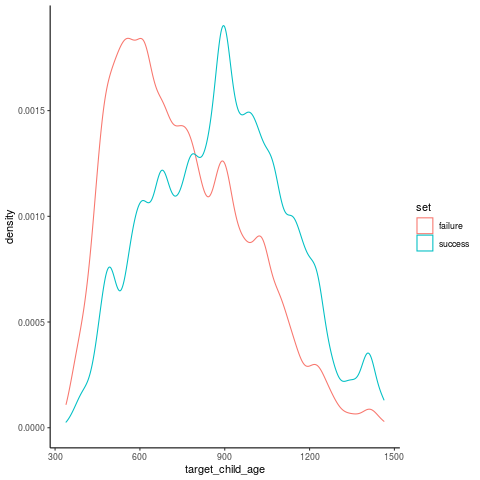

In [68]:
%%R
### Number of utterances by Age
ggplot(utts_with_ages) + geom_density(aes(x=target_child_age, color=set)) + theme_classic()

In [69]:
utts_with_ages['year'] = .5*np.floor(utts_with_ages['target_child_age'] / (365. /2) ) 
print(utts_with_ages.loc[utts_with_ages.set == 'failure'].year.value_counts())
print(utts_with_ages.loc[utts_with_ages.set == 'success'].year.value_counts())

1.5    9919
2.0    7261
1.0    6693
2.5    4895
3.0    2097
3.5     414
0.5     167
4.0      11
Name: year, dtype: int64
2.0    22432
2.5    21194
1.5    16798
3.0    12564
1.0     6697
3.5     3683
4.0      379
0.5      133
Name: year, dtype: int64


# Load a Set of Models

In [70]:
models = [
    {
        'title': 'CHILDES BERT, replication, same utt only', 
        'kwargs': {
            'modelLM': replication_LM,
            'tokenizer': replication_tokenizer,
            'softmax_mask' : replication_softmax_mask,
            'context_width_in_utts' : 0,
            'use_speaker_labels' : False,
        },
        'type' : 'BERT'
    },
    {
        'title': 'CHILDES BERT, speaker tags, same utt only', 
        'kwargs': {
            'modelLM': with_tags_LM,
            'tokenizer': with_tags_tokenizer,
            'softmax_mask' : with_tags_softmax_mask,
            'context_width_in_utts' : 0,
            'use_speaker_labels' : True,
        },
        'type' : 'BERT',
    },
    {
        'title': 'CHILDES BERT with speaker, +-20 utts context', 
        'kwargs': {
            'modelLM': with_tags_LM,
            'tokenizer': with_tags_tokenizer,
            'softmax_mask' : with_tags_softmax_mask,
            'context_width_in_utts' : 20,
            'use_speaker_labels' : True,
        },
        'type' : 'BERT',
    },
    {'title': 'CHILDES BERT, +-20 utts context',
     'kwargs': {'modelLM': ft1_bertMaskedLM,
                'tokenizer': ft1_tokenizer,
                'softmax_mask': ft1_softmax_mask,
                'context_width_in_utts': 20,
                'use_speaker_labels':False
               },
     'type': 'BERT'
    },
    {'title': 'CHILDES BERT, same utt only',
     'kwargs': {'modelLM': ft1_bertMaskedLM,
                'tokenizer': ft1_tokenizer,
                'softmax_mask': ft1_softmax_mask,
                'context_width_in_utts': 0,
                'use_speaker_labels':False
               },
     'type': 'BERT'
    },
    {'title': 'Adult BERT, +-20 utts context',
    'kwargs': {'modelLM': adult_bertMaskedLM,
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'context_width_in_utts': 20,
               'use_speaker_labels':False
               },
     'type': 'BERT'
    },
    {'title': 'Adult BERT, same utt only',
    'kwargs': {'modelLM': adult_bertMaskedLM,
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'context_width_in_utts': 0,
               'use_speaker_labels':False
               },
     'type': 'BERT'
    },        
    {'title': 'CHILDES Unigram',
    'kwargs': {'child_counts_path': 'data/chi_vocab.csv',
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'vocab': initial_vocab
               },
     'type': 'unigram'
    },
    {'title': 'Flat Unigram',
    'kwargs': {'child_counts_path': None,
                'tokenizer': adult_tokenizer,
                'softmax_mask': adult_softmax_mask,
                'vocab': initial_vocab
               },
     'type': 'unigram'
    }
]

# Find the Best Value of $\beta$

In [71]:
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [72]:
# maximize the posterior by iterating over beta values
success_utts_for_beta_fitting = success_utts.sample(1000, replace=False).utterance_id
success_utts_for_beta_fitting

test_beta_vals = np.arange(2.5,3.5,.1)
beta_results = transfomers_bert_completions.sample_across_models(success_utts_for_beta_fitting, success_utts, yyy_utts, 
    all_tokens_phono, models[0:1], initial_vocab, cmu_in_initial_vocab, beta_values =
                     test_beta_vals)

beta_results_surp = beta_results.groupby(['beta_value']).posterior_surprisal.agg(lambda x: np.mean(-1 * np.log(x))
).reset_index()
%R -i beta_results_surp

Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores


In [73]:
# something wrong with model feeding for successful utterances
# this has chi in the dataset -- IIRC it should always be there, just it is not always used
# the id is repeated across multiple token records. Is this the same as success_id? 
# this seems like it has something to do with the retrival of context

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


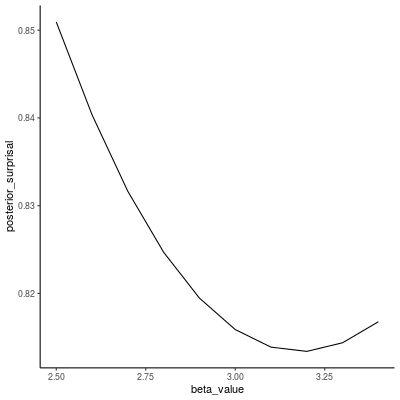

In [74]:
%%R -w 400 -h 400
ggplot(beta_results_surp) + geom_line(aes(x=beta_value, y=posterior_surprisal)) + theme_classic()

# Run Models Across Time

In [75]:
# this takes a long time -- 6 hours?
regenerate = True
if regenerate:
    scores_across_time = transfomers_bert_completions.sample_models_across_time(utts_with_ages, 
    all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab)
    scores_across_time.to_pickle('pkl/scores_across_time.pkl')
else:
    scores_across_time = pd.read_pickle('pkl/scores_across_time.pkl')

Running models for age 0.5
Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, same utt only...
Computing failure scores
Computing success scores
Running model Adult BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, same utt only...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 1.0
Running model CHILDES BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model CHILDES BERT, same utt only...
Computing failure scores
Computing success scores
Running model Adult BERT, +-20 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, same utt only...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 1.5
Running model CHILDES BER

scores_across_time.set.value_counts()

In [76]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
%%R
library('plyr')
# rename the models
model_levels = c("CHILDES BERT, +-20 utts context", "CHILDES BERT, same utt only", 
           "Adult BERT, +-20 utts context",  "Adult BERT, same utt only",
            "CHILDES Unigram", "Flat Unigram")
model_new_levels =  c("CHILDES BERT, +-20 utts context"="CDL+Context",
            "CHILDES BERT, same utt only" = "CDL+OneUtt",
          "Adult BERT, +-20 utts context" = "BERT+Context",
          "Adult BERT, same utt only" = "BERT+OneUtt",
            "CHILDES Unigram" = "CHILDES 1gram",
            "Flat Unigram" = "UniformPrior"
)
scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# Average Prior Surprisal

In [78]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

          model prior_surprisal
1   CDL+Context        3.187448
2    CDL+OneUtt        5.370613
3  BERT+Context        4.596843
4   BERT+OneUtt        7.189294
5 CHILDES 1gram        8.820670
6  UniformPrior       12.948367


In [79]:
%%R
library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id  CDL+Context   CDL+OneUtt BERT+Context  BERT+OneUtt
1           170 0.0474744104 0.0003635775 0.0003539369 3.337303e-06
2          1529 0.0001056695 0.0050619622 0.0002259925 2.206714e-04
3          3183 0.9152318835 0.0003635775 0.0686693490 3.337303e-06
4          4740 0.3003358841 0.0003072216 0.0078858957 3.062891e-06
5          5590 0.9687192440 0.0026838621 0.0295563955 5.763856e-05
6          8919 0.0018478251 0.0042625805 0.0005942492 1.553990e-05
  CHILDES 1gram UniformPrior
1  0.0005544385 0.0001265182
2  0.0037258323 0.0001265182
3  0.0005544385 0.0001265182
4  0.0032730595 0.0001265182
5  0.0008678585 0.0001265182
6  0.0096780848 0.0001265182


In [80]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

              CDL+Context CDL+OneUtt  BERT+Context  BERT+OneUtt CHILDES 1gram
CDL+Context            NA          0  0.000000e+00  0.00000e+00  0.000000e+00
CDL+OneUtt              0         NA  0.000000e+00  0.00000e+00  0.000000e+00
BERT+Context            0          0            NA 7.87119e-114 2.827249e-260
BERT+OneUtt             0          0 7.871190e-114           NA  0.000000e+00
CHILDES 1gram           0          0 2.827249e-260  0.00000e+00            NA
UniformPrior            0          0  0.000000e+00  0.00000e+00  0.000000e+00
              UniformPrior
CDL+Context              0
CDL+OneUtt               0
BERT+Context             0
BERT+OneUtt              0
CHILDES 1gram            0
UniformPrior            NA


### Posterior Surprisal Across Ages

In [81]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age         model posterior_surprisal_mean posterior_surprisal_sem
1  0.5  BERT+Context                2.3319557              0.39670827
2  0.5   BERT+OneUtt                5.1606237              0.68772000
3  0.5   CDL+Context                1.2343716              0.27631901
4  0.5    CDL+OneUtt                3.3271563              0.52168239
5  0.5 CHILDES 1gram                3.6790926              0.51154137
6  0.5  UniformPrior                4.4973854              0.47833772
7  1.5  BERT+Context                1.6667110              0.10158131
8  1.5   BERT+OneUtt                3.0573484              0.12861877
9  1.5   CDL+Context                1.0996591              0.08327767
10 1.5    CDL+OneUtt                2.2108447              0.10936128
11 1.5 CHILDES 1gram                3.5240617              0.12650450
12 1.5  UniformPrior                4.2744151              0.11307792
13 1.0  BERT+Context                2.9984046              0.14885736
14 1.0   BERT+OneUtt

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,BERT+Context,2.331956,0.396708
2,0.5,BERT+OneUtt,5.160624,0.687720
3,0.5,CDL+Context,1.234372,0.276319
4,0.5,CDL+OneUtt,3.327156,0.521682
5,0.5,CHILDES 1gram,3.679093,0.511541
6,0.5,UniformPrior,4.497385,0.478338
7,1.5,BERT+Context,1.666711,0.101581
8,1.5,BERT+OneUtt,3.057348,0.128619
9,1.5,CDL+Context,1.099659,0.083278
10,1.5,CDL+OneUtt,2.210845,0.109361


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


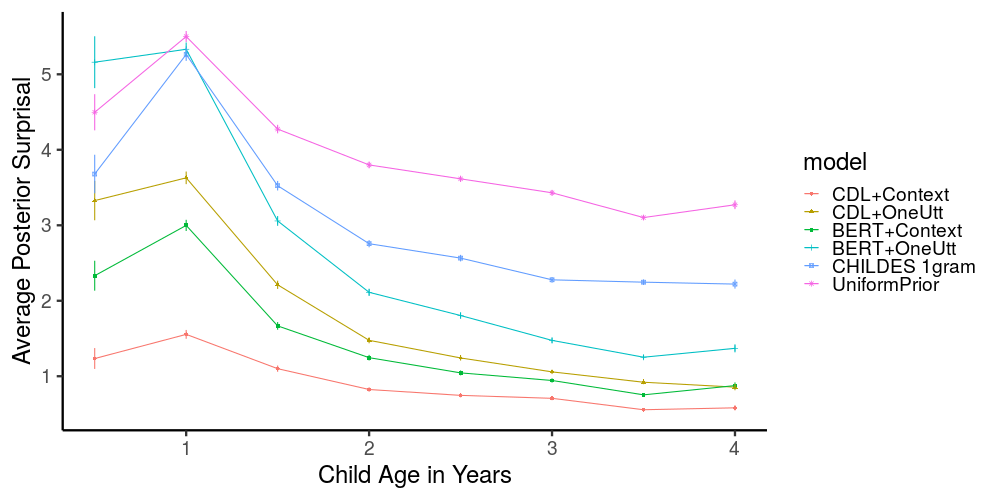

In [82]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [83]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,BERT+Context,5.348536,0.201515
2,0.5,BERT+OneUtt,9.231810,0.396100
3,0.5,CDL+Context,2.048350,0.178949
4,0.5,CDL+OneUtt,5.557589,0.274316
5,0.5,CHILDES 1gram,9.074144,0.096498
6,0.5,UniformPrior,12.948367,0.000000
7,1.5,BERT+Context,4.902226,0.085775
8,1.5,BERT+OneUtt,8.648077,0.096643
9,1.5,CDL+Context,3.150805,0.075195
10,1.5,CDL+OneUtt,6.488202,0.082247


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


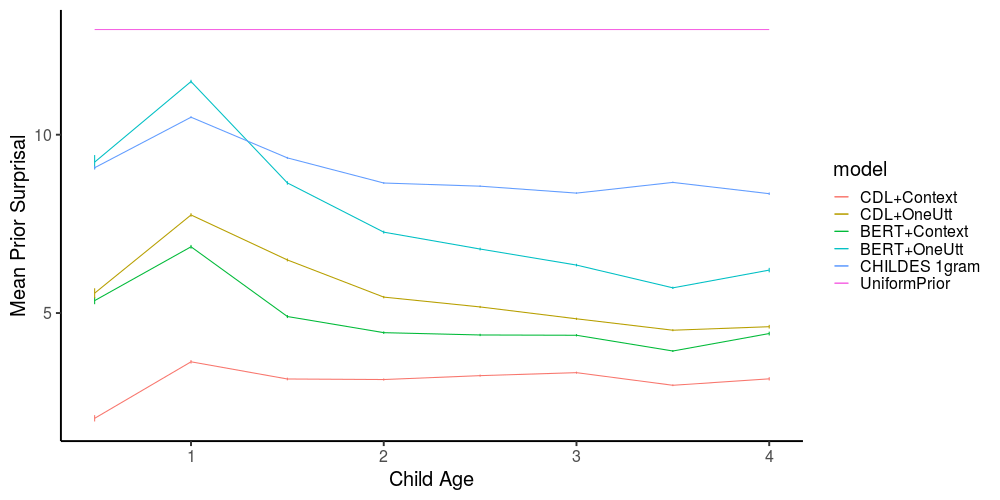

In [84]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [85]:
scores_across_time_short.set.value_counts()

success    88158
failure    33552
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [86]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,BERT+Context,failure,3.140225,0.082138
2,0.5,BERT+Context,success,1.321636,0.099834
3,0.5,BERT+OneUtt,failure,3.422119,0.078621
4,0.5,BERT+OneUtt,success,1.768958,0.111789
5,0.5,CDL+Context,failure,2.611891,0.093699
...,...,...,...,...,...
92,4.0,CDL+OneUtt,success,0.833137,0.033435
93,4.0,CHILDES 1gram,failure,2.854018,0.227300
94,4.0,CHILDES 1gram,success,2.079981,0.037202
95,4.0,UniformPrior,failure,5.122522,0.232140


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


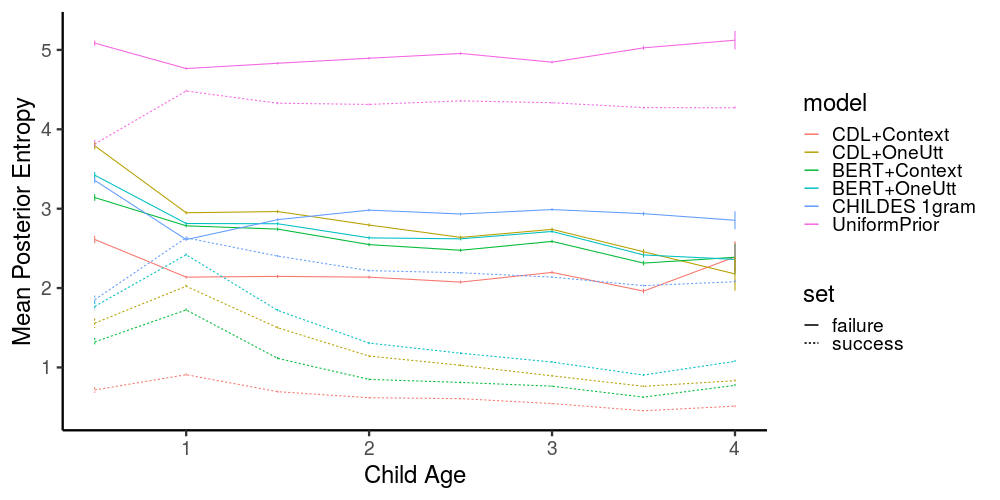

In [87]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# Information Gain 

In [88]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [89]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age         model      gain   gain_sem comparison age_in_months
1 0.5  BERT+Context 18.401410 0.33068583  posterior             6
2 0.5   BERT+OneUtt 19.458784 0.62006505  posterior             6
3 0.5   CDL+Context 24.795004 0.49328006  posterior             6
4 0.5    CDL+OneUtt 22.667585 0.78647474  posterior             6
5 0.5 CHILDES 1gram 17.298959 0.16667027  posterior             6
6 0.5  UniformPrior  9.104747 0.09739289  posterior             6


In [90]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model     gain   gain_sem comparison age_in_months
6  0.5 UniformPrior 9.104747 0.09739289  posterior             6
12 1.5 UniformPrior 8.807559 0.03894326  posterior            18
18 1.0 UniformPrior 8.476178 0.04435888  posterior            12
24 2.5 UniformPrior 8.858700 0.03081213  posterior            30
30 2.0 UniformPrior 8.880375 0.03292231  posterior            24
36 3.5 UniformPrior 9.032059 0.02880825  posterior            42
42 3.0 UniformPrior 8.976145 0.03260688  posterior            36
48 4.0 UniformPrior 9.124695 0.05074393  posterior            48


In [91]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [92]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

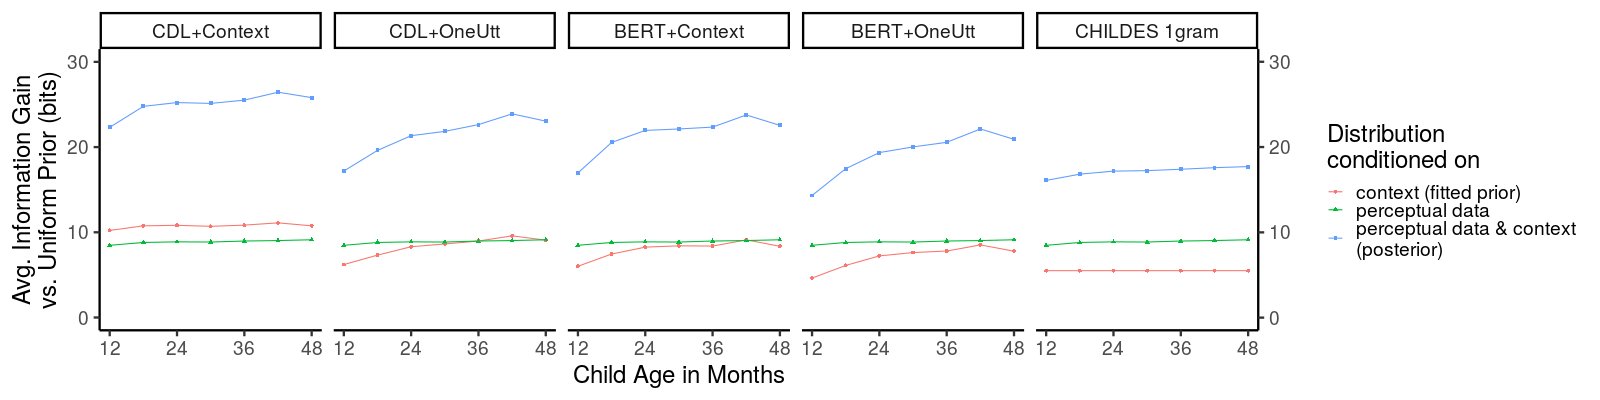

In [93]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# Posterior Probability as a function of edit distance

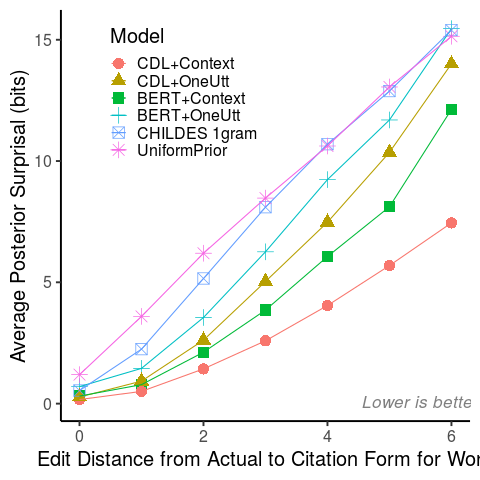

In [94]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [95]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance         model mean_posterior_surprisal
1              0  BERT+Context                0.3111492
2              0   BERT+OneUtt                0.7017496
3              0   CDL+Context                0.1691063
4              0    CDL+OneUtt                0.2727383
5              0 CHILDES 1gram                0.5405583
6              0  UniformPrior                1.1950986
7              1  BERT+Context                0.7831149
8              1   BERT+OneUtt                1.4536536
9              1   CDL+Context                0.5046720
10             1    CDL+OneUtt                0.9284947
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                   0.012140270 0.3111492 0.3111492           1.195099
2                   0.017753029 0.7017496 0.7017496           1.195099
3                   0.009044973 0.1691063 0.1691063           1.195099
4                   0.009900658 0.2727383 0.2727383           1.195099
5                   0.0113377

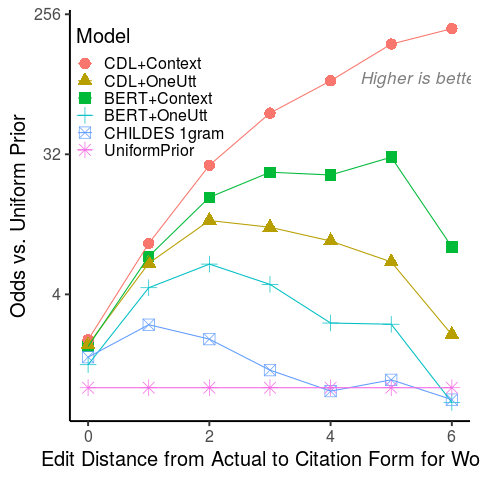

In [96]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

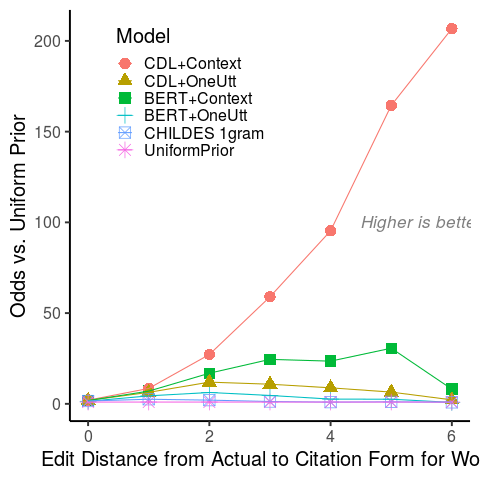

In [97]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# ROC for Completions 

In [98]:
%%R
library(plotROC)

In [99]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 88158 33552


In [100]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

[1] "CDL+Context"   "CDL+OneUtt"    "BERT+Context"  "BERT+OneUtt"  
[5] "CHILDES 1gram" "UniformPrior" 


In [101]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [102]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [103]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [3] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [5] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [7] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [9] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"


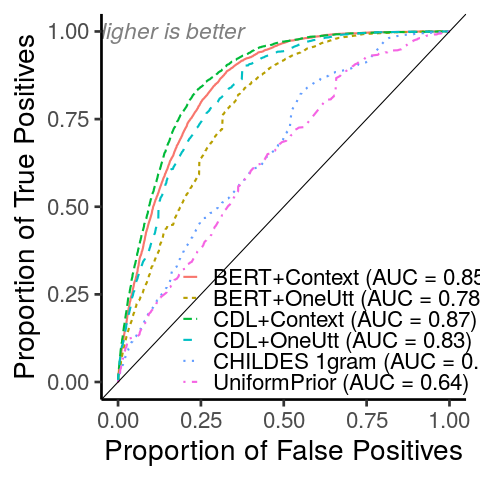

In [104]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=8, width=8)    